# Tutorial Part 16: Conditional Generative Adversarial Network

*Note: This example implements a GAN from scratch.  The same model could be implemented much more easily with the `dc.models.GAN` class.  See the MNIST GAN notebook for an example of using that class.  It can still be useful to know how to implement a GAN from scratch for advanced situations that are beyond the scope of what the standard GAN class supports.*

A Generative Adversarial Network (GAN) is a type of generative model.  It consists of two parts called the "generator" and the "discriminator".  The generator takes random values as input and transforms them into an output that (hopefully) resembles the training data.  The discriminator takes a set of samples as input and tries to distinguish the real training samples from the ones created by the generator.  Both of them are trained together.  The discriminator tries to get better and better at telling real from false data, while the generator tries to get better and better at fooling the discriminator.

A Conditional GAN (CGAN) allows additional inputs to the generator and discriminator that their output is conditioned on.  For example, this might be a class label, and the GAN tries to learn how the data distribution varies between classes.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/16_Conditional_Generative_Adversarial_Networks.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [0]:
%%capture
%tensorflow_version 1.x
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

For this example, we will create a data distribution consisting of a set of ellipses in 2D, each with a random position, shape, and orientation.  Each class corresponds to a different ellipse.  Let's randomly generate the ellipses.

In [2]:
import deepchem as dc
import numpy as np
import tensorflow as tf

n_classes = 4
class_centers = np.random.uniform(-4, 4, (n_classes, 2))
class_transforms = []
for i in range(n_classes):
    xscale = np.random.uniform(0.5, 2)
    yscale = np.random.uniform(0.5, 2)
    angle = np.random.uniform(0, np.pi)
    m = [[xscale*np.cos(angle), -yscale*np.sin(angle)],
         [xscale*np.sin(angle), yscale*np.cos(angle)]]
    class_transforms.append(m)
class_transforms = np.array(class_transforms)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



This function generates random data from the distribution.  For each point it chooses a random class, then a random position in that class' ellipse.

In [0]:
def generate_data(n_points):
    classes = np.random.randint(n_classes, size=n_points)
    r = np.random.random(n_points)
    angle = 2*np.pi*np.random.random(n_points)
    points = (r*np.array([np.cos(angle), np.sin(angle)])).T
    points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
    points += class_centers[classes]
    return classes, points

Let's plot a bunch of random points drawn from this distribution to see what it looks like.  Points are colored based on their class label.

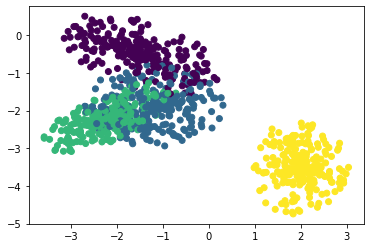

In [4]:
%matplotlib inline
import matplotlib.pyplot as plot
classes, points = generate_data(1000)
plot.scatter(x=points[:,0], y=points[:,1], c=classes)

Now let's create the model for our CGAN.

In [0]:
import deepchem.models.tensorgraph.layers as layers
model = dc.models.TensorGraph(learning_rate=1e-4, use_queue=False)

# Inputs to the model

random_in = layers.Feature(shape=(None, 10)) # Random input to the generator
generator_classes = layers.Feature(shape=(None, n_classes)) # The classes of the generated samples
real_data_points = layers.Feature(shape=(None, 2)) # The training samples
real_data_classes = layers.Feature(shape=(None, n_classes)) # The classes of the training samples
is_real = layers.Weights(shape=(None, 1)) # Flags to distinguish real from generated samples

# The generator

gen_in = layers.Concat([random_in, generator_classes])
gen_dense1 = layers.Dense(30, in_layers=gen_in, activation_fn=tf.nn.relu)
gen_dense2 = layers.Dense(30, in_layers=gen_dense1, activation_fn=tf.nn.relu)
generator_points = layers.Dense(2, in_layers=gen_dense2)
model.add_output(generator_points)

# The discriminator

all_points = layers.Concat([generator_points, real_data_points], axis=0)
all_classes = layers.Concat([generator_classes, real_data_classes], axis=0)
discrim_in = layers.Concat([all_points, all_classes])
discrim_dense1 = layers.Dense(30, in_layers=discrim_in, activation_fn=tf.nn.relu)
discrim_dense2 = layers.Dense(30, in_layers=discrim_dense1, activation_fn=tf.nn.relu)
discrim_prob = layers.Dense(1, in_layers=discrim_dense2, activation_fn=tf.sigmoid)

We'll use different loss functions for training the generator and discriminator.  The discriminator outputs its predictions in the form of a probability that each sample is a real sample (that is, that it came from the training set rather than the generator).  Its loss consists of two terms.  The first term tries to maximize the output probability for real data, and the second term tries to minimize the output probability for generated samples.  The loss function for the generator is just a single term: it tries to maximize the discriminator's output probability for generated samples.

For each one, we create a "submodel" specifying a set of layers that will be optimized based on a loss function.

In [0]:
# Discriminator

discrim_real_data_loss = -layers.Log(discrim_prob+1e-10) * is_real
discrim_gen_data_loss = -layers.Log(1-discrim_prob+1e-10) * (1-is_real)
discrim_loss = layers.ReduceMean(discrim_real_data_loss + discrim_gen_data_loss)
discrim_submodel = model.create_submodel(layers=[discrim_dense1, discrim_dense2, discrim_prob], loss=discrim_loss)

# Generator

gen_loss = -layers.ReduceMean(layers.Log(discrim_prob+1e-10) * (1-is_real))
gen_submodel = model.create_submodel(layers=[gen_dense1, gen_dense2, generator_points], loss=gen_loss)

Now to fit the model.  Here are some important points to notice about the code.

- We use `fit_generator()` to train only a single batch at a time, and we alternate between the discriminator and the generator.  That way. both parts of the model improve together.
- We only train the generator half as often as the discriminator.  On this particular model, that gives much better results.  You will often need to adjust `(# of discriminator steps)/(# of generator steps)` to get good results on a given problem.
- We disable checkpointing by specifying `checkpoint_interval=0`.  Since each call to `fit_generator()` includes only a single batch, it would otherwise save a checkpoint to disk after every batch, which would be very slow.  If this were a real project and not just an example, we would want to occasionally call `model.save_checkpoint()` to write checkpoints at a reasonable interval.

In [7]:
batch_size = model.batch_size
discrim_error = []
gen_error = []
for step in range(20000):
    classes, points = generate_data(batch_size)
    class_flags = dc.metrics.to_one_hot(classes, n_classes)
    feed_dict={random_in: np.random.random((batch_size, 10)),
               generator_classes: class_flags,
               real_data_points: points,
               real_data_classes: class_flags,
               is_real: np.concatenate([np.zeros((batch_size,1)), np.ones((batch_size,1))])}
    discrim_error.append(model.fit_generator([feed_dict],
                                             submodel=discrim_submodel,
                                             checkpoint_interval=0))
    if step%2 == 0:
        gen_error.append(model.fit_generator([feed_dict],
                                             submodel=gen_submodel,
                                             checkpoint_interval=0))
    if step%1000 == 999:
        print(step, np.mean(discrim_error), np.mean(gen_error))
        discrim_error = []
        gen_error = []


Instructions for updating:
If using Keras pass *_constraint arguments to layers.







999 0.5353480346798897 0.42010479140281676
1999 0.4970605837404728 0.5927191683650017
2999 0.32337378211319445 0.7835518234968185
3999 0.6442742827236653 0.44793607395887375
4999 0.7197044906020165 0.3560899528264999
5999 0.6842574814558029 0.35353413671255113
6999 0.681817068874836 0.35413561046123504
7999 0.6773326816558838 0.36418179589509964
8999 0.680501739025116 0.3696627883315086
9999 0.6853346248865128 0.35303945660591124
10999 0.6879503725767135 0.35497990638017657
11999 0.6917924422621727 0.3506708189845085
12999 0.6924710651636123 0.3495020810961723
13999 0.6911373255252838 0.3482625074982643
14999 0.6910281682610512 0.35186264622211455
15999 0.6905803002119064 0.3522126387357712
16999 0.6895883530378342 0.3526522752642631
17999 0.6900975884199142 0.35136979585886
18999 0.6905963387489319 0.34954379898309706
19999 0.6901651693582534 0.3524894942045212


Have the trained model generate some data, and see how well it matches the training distribution we plotted before.

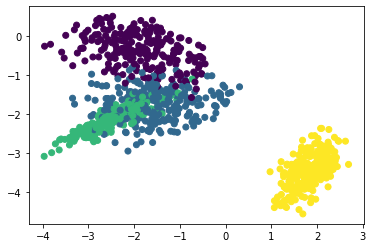

In [8]:
classes, points = generate_data(1000)
feed_dict = {random_in: np.random.random((1000, 10)),
             generator_classes: dc.metrics.to_one_hot(classes, n_classes)}
gen_points = model.predict_on_generator([feed_dict])
plot.scatter(x=gen_points[:,0], y=gen_points[:,1], c=classes)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!